<h1>BiLSTM with overlap</h1>
<h3>Last sequence from train data is add to test data to maintain continuation during plotting</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']]
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.set_index('Order Date', inplace=True)

monthly_df = df['Total Profit'].resample('ME').sum().to_frame()

print("Index frequency:", monthly_df.index.freq)

Index frequency: <MonthEnd>


In [3]:
monthly_df

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-02-28,1.402973e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
...,...
2024-05-31,1.558589e+10
2024-06-30,1.506300e+10
2024-07-31,1.553073e+10


In [4]:
train_data, test_data = train_test_split(monthly_df, test_size= 0.2, shuffle=False)

In [5]:
train_data

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-02-28,1.402973e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
...,...
2022-03-31,1.557572e+10
2022-04-30,1.508754e+10
2022-05-31,1.565507e+10


In [6]:
test_data

,Total Profit
Order Date,
2022-08-31,1.561939e+10
2022-09-30,1.507442e+10
2022-10-31,1.561683e+10
2022-11-30,1.509961e+10
2022-12-31,1.562022e+10
2023-01-31,1.559258e+10
2023-02-28,1.407188e+10
2023-03-31,1.555777e+10
2023-04-30,1.512009e+10


In [7]:
test_data = test_data[:-1].copy()

In [8]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[["Total Profit"]])
test_scaled = scaler.transform(test_data[["Total Profit"]])
train_data["Total Profit"] = train_scaled.astype(float)
test_data["Total Profit"] = test_scaled.astype(float)

In [9]:
#Creating Sequences for BiLSTM

def create_sequences(data, dates, seq_length):
    X, y, seq_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        seq_dates.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(seq_dates)

seq_length = 12

X_train, y_train, train_dates = create_sequences(
    train_data["Total Profit"].values,
    train_data.index,
    seq_length
)

# Overlap from the end of train data to test data
test_input = np.concatenate([
    train_data["Total Profit"].values[-seq_length:],  # last 12 from train
    test_data["Total Profit"].values
])
test_input_dates = np.concatenate([
    train_data.index[-seq_length:],
    test_data.index
])

X_test, y_test, test_dates = create_sequences(
    test_input,
    test_input_dates,
    seq_length
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [10]:
model = Sequential([
    Bidirectional(LSTM(64, input_shape=(seq_length, 1))),
    Dense(1)
])

In [11]:
model.compile(optimizer='adam', loss='mae', metrics='mae')

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience= 100, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs= 100, batch_size= 16, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 6s 148ms/step - loss: 0.4511 - mae: 0.4511 - val_loss: 0.2013 - val_mae: 0.2013
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.2244 - mae: 0.2244 - val_loss: 0.1908 - val_mae: 0.1908
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1770 - mae: 0.1770 - val_loss: 0.1872 - val_mae: 0.1872
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.2002 - mae: 0.2002 - val_loss: 0.1975 - val_mae: 0.1975
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.2015 - mae: 0.2015 - val_loss: 0.1847 - val_mae: 0.1847
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.1862 - mae: 0.1862 - val_loss: 0.1672 - val_mae: 0.1672
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1726 - mae: 0.1726 - val_loss: 0.1622 - val_mae: 0.1622
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1722 - mae: 0.1

In [13]:
model.save("bilstm_model_with_overlap.keras")

3/3 [==============================] - 0s 3ms/step
MAPE: 0.48%
MAPA (Accuracy): 99.52%
RMSE: 94582541.29
MinMax Error: 0.0048
MPE: -0.20%
Correlation: 0.9735


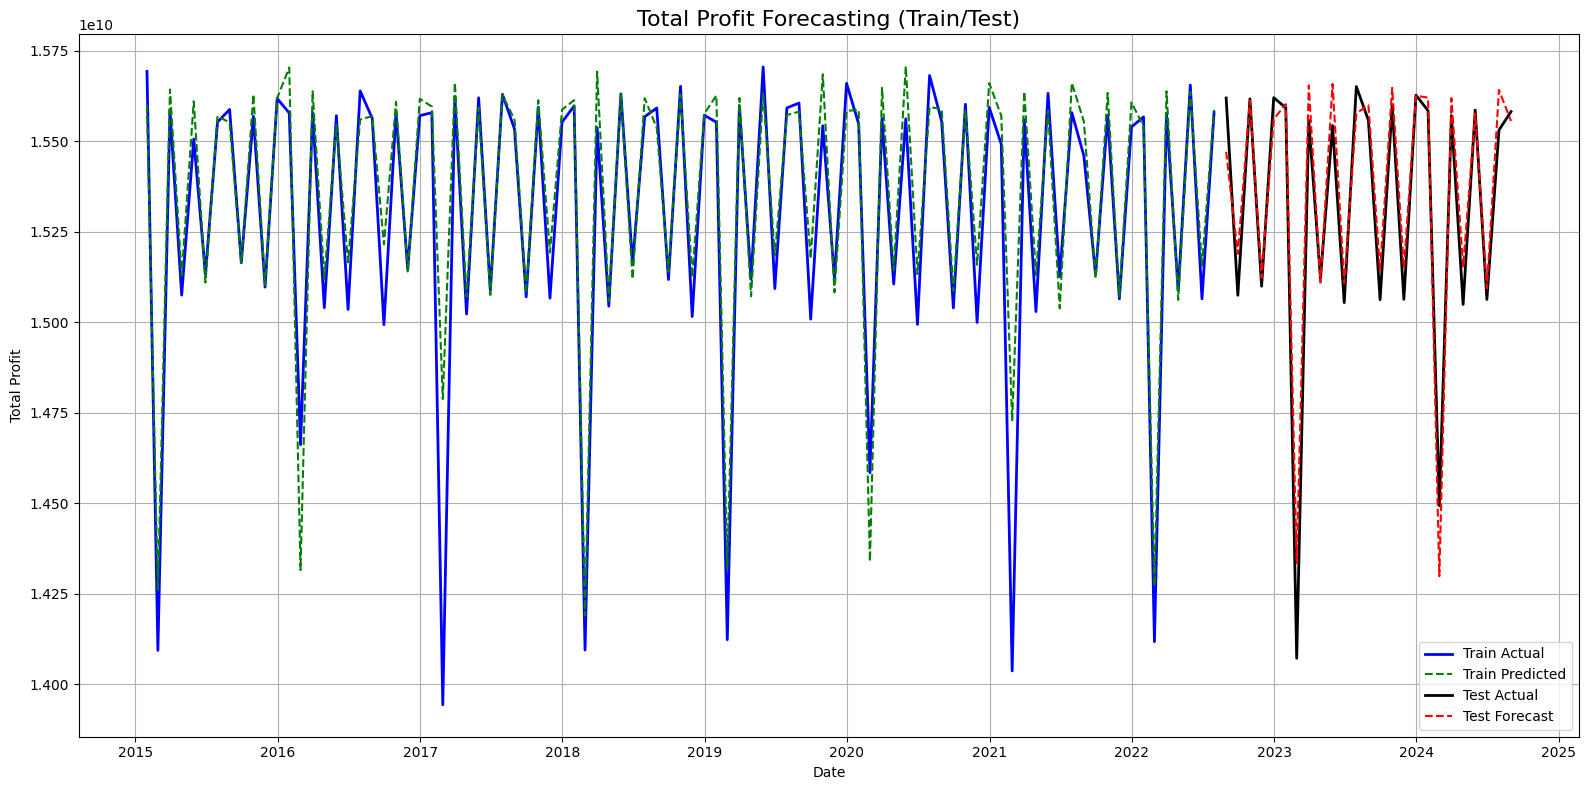

In [17]:
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler.inverse_transform(train_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
accuracy = 100 - mape

y_true = y_test_inv.flatten()
y_pred = y_pred_inv.flatten()

min_vals = np.minimum(np.abs(y_true), np.abs(y_pred))
minmax_errors = np.abs(y_true - y_pred) / min_vals
minmax_error = np.mean(minmax_errors)

mpe = np.mean((y_true - y_pred) / y_true) * 100

correlation = np.corrcoef(y_true, y_pred)[0, 1]

print(f"MAPE: {mape:.2f}%")
print(f"MAPA (Accuracy): {accuracy:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MinMax Error: {minmax_error:.4f}")
print(f"MPE: {mpe:.2f}%")
print(f"Correlation: {correlation:.4f}")

plt.figure(figsize=(16, 8))

plt.plot(train_dates, y_train_inv, label='Train Actual', color='blue', linewidth=2)
plt.plot(train_dates, y_train_pred_inv, label='Train Predicted', color='green', linestyle='--')

plt.plot(test_dates, y_test_inv, label='Test Actual', color='black', linewidth=2)
plt.plot(test_dates, y_pred_inv, label='Test Forecast', color='red', linestyle='--')


plt.title('Total Profit Forecasting (Train/Test)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 19ms/step


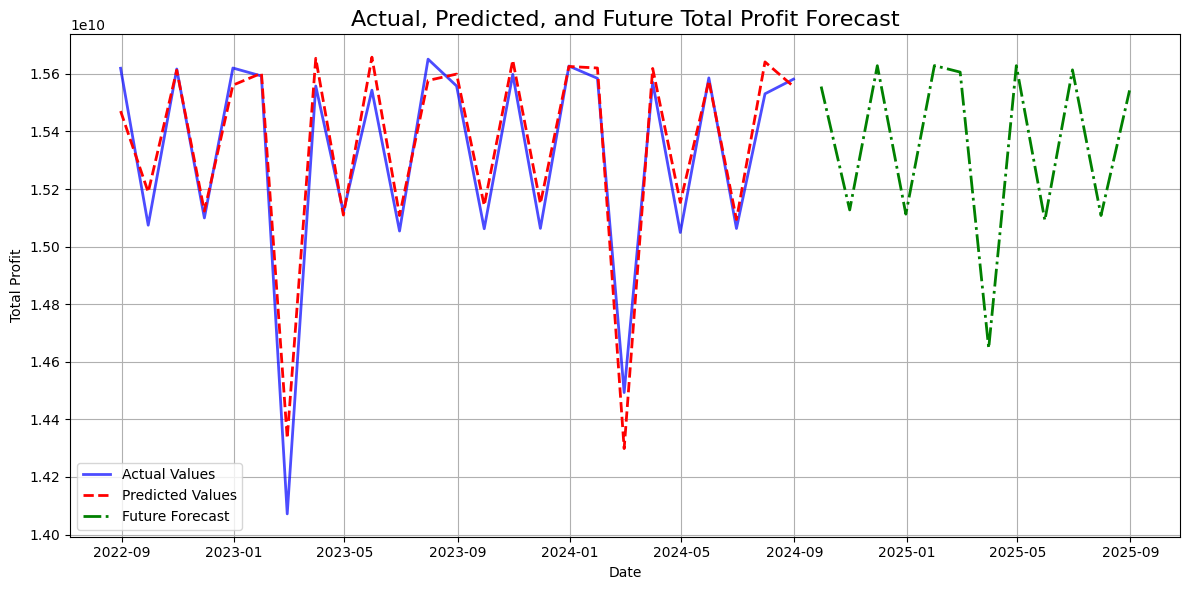

In [15]:
last_sequence = X_test[-1:]
future_preds = []
for _ in range(12):
    pred = model.predict(last_sequence)[0][0]
    future_preds.append(pred)

    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

last_date = test_dates[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=12, freq='ME')

plt.figure(figsize=(12, 6))

plt.plot(test_dates, y_test_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)
plt.plot(test_dates, y_pred_inv, 'r--', linewidth=2, label='Predicted Values')

plt.plot(future_dates, future_preds, 'g-.', linewidth=2, label='Future Forecast')


plt.title('Actual, Predicted, and Future Total Profit Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()